In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
smiles_and_names[0][0]

'COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O'

In [4]:
smiles_and_names[0]

('COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O',
 '5-hydroxy-6-(methoxymethyl)-2-(4-methoxyphenyl)-8-methyl-7-{[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-2,3-dihydro-1-benzopyran-4-one',
 506.5040000000003,
 'dataset_train_1d')

In [5]:
from inference.inference_utils import choose_model 
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [6]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)
datamodule.setup("test")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.test_dataloader()


loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [8]:
max_radius = fp_loader.max_radius

rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [9]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)


(526316, 526316)

In [10]:
from torch.nn.functional import cosine_similarity
import tqdm
model.setup_ranker()
model.ranker.data = model.ranker.data.to(model.device)

loading /root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_6_dim_16384_stacked_together/FP.pt


In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_topk_accuracy(mean_rank_records, max_k=50, title="Structure Dereplication (Similarity = 1.0)"):
    """
    Plot Top-K accuracy curves for different models.
    
    Args:
        mean_rank_records (dict): Dictionary mapping model names to lists of ranks
        max_k (int): Maximum K value to plot
        title (str): Plot title
    """
    
    plt.figure(figsize=(10, 8))
    
    # Define colors for different models (you can customize these)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    for i, (model_name, ranks) in enumerate(sorted(mean_rank_records.items())):
        # Calculate Top-K accuracy for each K from 1 to max_k
        topk_accuracies = []
        
        for k in range(1, max_k + 1):
            # Count how many predictions are correct within top-k
            correct_count = sum(1 for rank in ranks if rank < k)
            accuracy = (correct_count / len(ranks)) * 100
            topk_accuracies.append(accuracy)
        
        # Plot the step curve
        x_values = range(1, max_k + 1)
        plt.step(x_values, topk_accuracies, 
                label=model_name, 
                color=colors[i % len(colors)],
                linewidth=1.3,
                where='post')
    
    # Customize the plot
    plt.xlabel('Top-K', fontsize=12)
    plt.ylabel('% of correctly identified spectra', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Set axis limits
    plt.xlim(0, max_k)
    plt.ylim(0, 100)
    
    # Add more tick marks on x-axis
    plt.xticks(range(0, max_k + 1, 5))
    plt.yticks(range(0, 101, 10))
    
    plt.tight_layout()
    plt.show()


In [2]:
# Order: [loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR]

loader_idx_to_name_mapping = {
    0: "All Inputs",
    1: "HSQC and H NMR",
    2: "HSQC and C NMR",
    3: "HSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Normal HSQC (Non-Multiplicity-Edited)",
}


In [13]:
from collections import defaultdict

## with MW
mean_rank_records = defaultdict(list)
for i in range(8):
    loader_idx = i
    if i == 7:
        loader_idx = 3
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        if i == 7:
            # last column all zeros
            batch[0][:, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records[loader_idx_to_name_mapping[i]].append(result['mean_rank'])

0it [00:00, ?it/s]

4056it [01:09, 58.06it/s]
4056it [01:07, 60.09it/s]
4056it [01:06, 61.02it/s]
4056it [01:05, 61.82it/s]
4056it [01:05, 61.95it/s]
4056it [01:07, 59.92it/s]
4056it [01:07, 60.51it/s]
4056it [01:05, 61.88it/s]


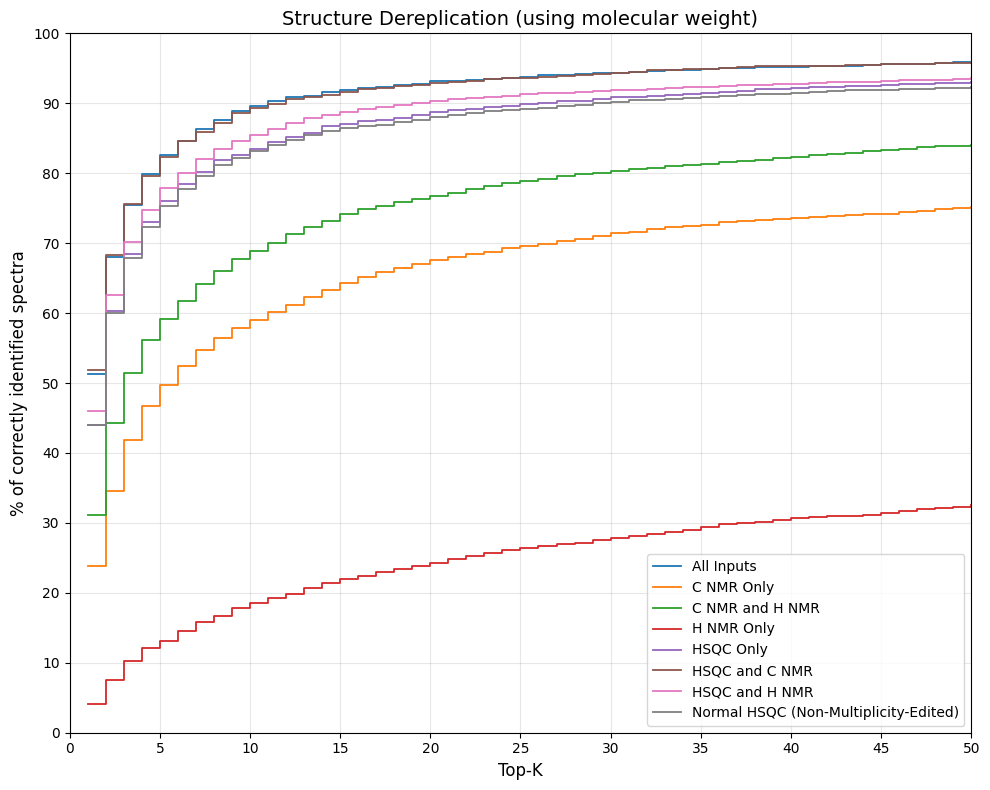

In [14]:
plot_topk_accuracy(mean_rank_records, title="Structure Dereplication (using molecular weight)")

In [15]:
for k,v in mean_rank_records.items():
    print(k, np.mean(v))

All Inputs 176.1429980276134
HSQC and H NMR 307.05029585798815
HSQC and C NMR 183.9940828402367
HSQC Only 261.038708086785
C NMR and H NMR 939.3971893491124
H NMR Only 12041.439102564103
C NMR Only 3053.9336785009864
Normal HSQC (Non-Multiplicity-Edited) 321.1895956607495


In [16]:

        
        
        
        

## without  MW
mean_rank_records_no_MW = defaultdict(list)
for i in range(8):
    loader_idx = i
    if i == 7:
        loader_idx = 3
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        # remove mw
        batch[0] = batch[0][:, :-1]
        # remove mw
        batch[2] = batch[2][:, :-1]
        
        if i == 7:
            # last column all zeros
            batch[0][:, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records_no_MW[loader_idx_to_name_mapping[i]].append(result['mean_rank'])        


7it [00:00, 60.76it/s]

4056it [01:06, 61.01it/s]
4056it [01:07, 60.25it/s]
4056it [01:06, 60.55it/s]
4056it [01:05, 61.69it/s]
4056it [01:06, 61.13it/s]
4056it [01:06, 61.40it/s]
4056it [01:06, 61.12it/s]
4056it [01:06, 60.86it/s]


In [4]:
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

# with open(save_dir + "topk_with_mw.pkl", 'wb') as file:
#     pickle.dump(mean_rank_records, file)
# with open(save_dir + "topk_without_mw.pkl", 'wb') as file:
#     pickle.dump(mean_rank_records_no_MW, file)

with open(save_dir + "topk_without_mw.pkl", 'rb') as file:
    mean_rank_records_no_MW = pickle.load(file)


In [5]:
import pickle
save_dir_ranking = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_inference_results/ranking_result/"

load_path = save_dir_ranking + "ranking.pkl"

with open(load_path, 'rb') as file:
    loaded = pickle.load(file)
mean_rank_records_no_MW["HSQC, by DeepSAT"] = loaded



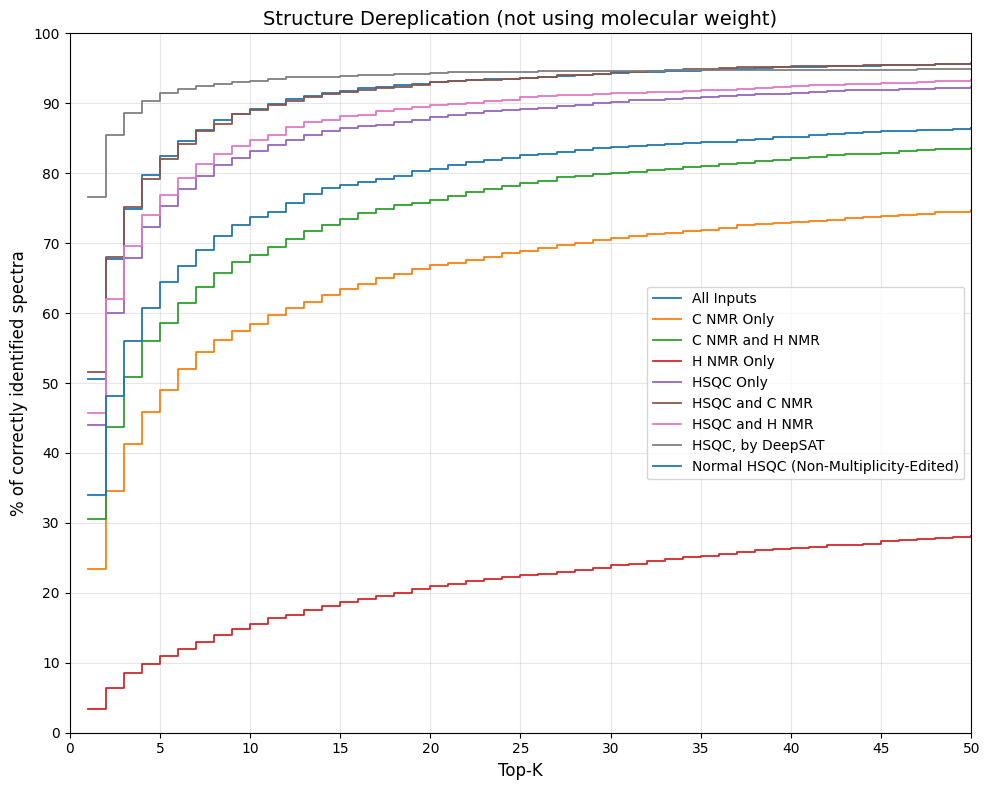

In [6]:
plot_topk_accuracy(mean_rank_records_no_MW, title="Structure Dereplication (not using molecular weight)")

In [10]:
from rdkit.Chem import rdFingerprintGenerator

def gen_mfp(smiles):
    MFP_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    mol = Chem.MolFromSmiles(smiles)
    fp = MFP_generator.GetFingerprint(mol)
    return torch.tensor(fp).float()

def cos_sim_of_smiles(smiles1, smiles2):
    fp1 = gen_mfp(smiles1)
    fp2 = gen_mfp(smiles2)
    cos_sim = torch.nn.functional.cosine_similarity(fp1, fp2, dim=0)
    return cos_sim.item()

In [30]:
total_cos = []
for idx, batch in tqdm.tqdm(enumerate(test_loader)):
    
    inputs, extra_info = batch
    (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
    # if (smiles[0]) == "COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3":
    #     print("Found the molecule")
    #     print(idx)
    #     break
    
    inputs = inputs.to(model.device)
    NMR_type_indicator = NMR_type_indicator[0].to(model.device)
    pred = model(inputs, NMR_type_indicator)
    pred=torch.sigmoid(pred) # sigmoid
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    i=0
    for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
            
        mfp_truth = gen_mfp(ground_smiles[i])
        mfp_pred = gen_mfp(retrieval_smile)
        cos_curr = cosine_similarity(mfp_truth, mfp_pred, dim=0)
        total_cos.append(cos_curr.item())
        # if retrieval_smile != ground_smiles[i]:
        #     print(f"Ground: {ground_smiles[i]}, Retrieval: {retrieval_smile}, Cosine: {cos_curr.item()}")
    # if idx == 5:
    #     break   

print(np.mean(total_cos))

0it [00:00, ?it/s]

4056it [01:08, 59.07it/s]

0.883331320099753


In [34]:
pred.max()

tensor(0.9975155592, device='cuda:0', grad_fn=<MaxBackward1>)

In [29]:
len(x)

16384

In [22]:
h_tensor

tensor([3.4200000763, 4.3099999428, 5.6500000954, 6.5100002289, 6.7699999809,
        7.3499999046, 3.2899999619, 6.9200000763, 6.7100000381])

In [14]:
inputs.shape, NMR_type_indicator.shape

(torch.Size([1, 10, 3]), torch.Size([10]))

In [15]:
NMR_type_indicator

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 3], device='cuda:0')

In [23]:
inputs

tensor([[[0.0000000000, 3.4200000763, 0.0000000000],
         [0.0000000000, 4.3099999428, 0.0000000000],
         [0.0000000000, 5.6500000954, 0.0000000000],
         [0.0000000000, 6.5100002289, 0.0000000000],
         [0.0000000000, 6.7699999809, 0.0000000000],
         [0.0000000000, 7.3499999046, 0.0000000000],
         [0.0000000000, 3.2899999619, 0.0000000000],
         [0.0000000000, 6.9200000763, 0.0000000000],
         [0.0000000000, 6.7100000381, 0.0000000000]]], device='cuda:0')

In [11]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [40]:
def draw_mol_from_dir(dir):
    """
    Draw the molecule from the directory
    """
    smiles_file = Path(dir) / "SMILES.txt"
    with open(smiles_file, "r") as f:
        smiles = f.read().strip()
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    display(img)
    
    return smiles, img

In [12]:
# look for the higher cos_sim possible in our dataset
from inference.inference_utils import show_retrieved_mol_with_highlighted_frags
def retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"retival #{i+1}, cosine similarity between retrieval and ground truth: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        # img = Draw.MolToImage(mol)
        img = show_retrieved_mol_with_highlighted_frags(groud_truth_FP[0], smile)
        img.show()
        
        # display(img)
        i+=1

In [13]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)


# Kavaratamide_A_bit_infos = count_circular_substructures(Kavaratamide_A_SMILES)

In [14]:
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


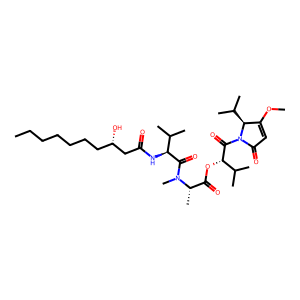

In [15]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img

retival #1, cosine similarity between retrieval and ground truth: 0.7378648519515991_____________________________
retrived FP [0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0,

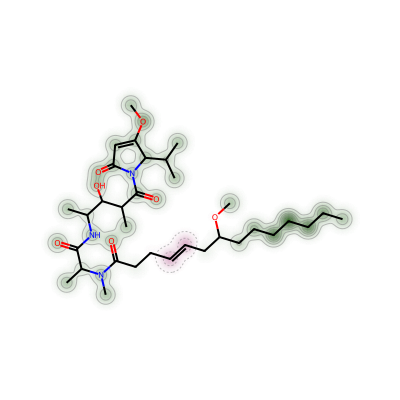

retival #2, cosine similarity between retrieval and ground truth: 0.6067880988121033_____________________________
retrived FP [0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.1714985966682434, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

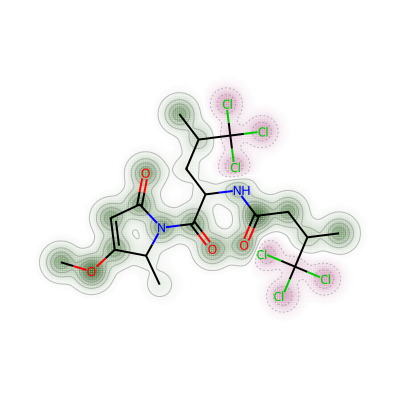

In [16]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)

In [47]:
def inference_topK_show_diff_frags(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=5,  
                   ground_smiles=None,
                   ):
    """
    Run inference on a given input tensor and visualize the top-k retrieved molecules.
    Hence, shape of inputs is (n, 3) where n is the number of NMR peaks (and other infos)
    """
    
   
    returning_smiles = []
    returning_names = []
    returning_imgs = []
    returning_values = []
    returning_MWs = []
    inputs = inputs.unsqueeze(0).to(model.device)
    NMR_type_indicator = NMR_type_indicator.to(model.device)
    rankingset_data = rankingset_data.to(model.device)
    pred = model(inputs, NMR_type_indicator)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    pred_on_bits = set(pred_FP.nonzero().squeeze().tolist())
    
    # print(pred_FP.nonzero().squeeze().tolist())
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k, filter_by_MW=None, weighting_pred = None)
    for value, (smile, name, mw, _), retrieved_FP in topk:
        print("Morgan FP similarity: ", cos_sim_of_smiles(smile, ground_smiles))
        print("Help me modify the following SMILES: ", smile)
        retrieval_on_bits = set(retrieved_FP.to_dense().nonzero().squeeze().tolist())
        print(f"We need to remove the following fragments from the smiles: ")
        for bit in pred_on_bits - retrieval_on_bits:
            print(fp_loader.fp_index_to_bitInfo_mapping[bit][2])
        print(f"\n\nAnd we need to add the following fragments to the smiles: ")
        for bit in retrieval_on_bits - pred_on_bits:
            print(fp_loader.fp_index_to_bitInfo_mapping[bit][2])
        img = show_retrieved_mol_with_highlighted_frags(pred[0], smile, img_size=400) #
        img.show()
            
    return returning_smiles, returning_names

In [52]:
from rdkit import Chem
from rdkit.Chem import AllChem

original_smiles = 'CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C'
remove_smiles = [
    'CC(C)N', 'CC(N)=O', 'CCCCC', 'CCC', 'CCCC', 'CCC', 'CCC', 'CCCCC', 'CCC'
]
add_smiles = [
    'CC(C)N', 'CC(C)O', 'CCC', 'CC(C)CC(C)N', 'CCN(C(C)=O)C(C)C', 'CCC',
    'CCCCN', 'CC(N)=O', 'CCN', 'CC(=O)N1CCCC1C', 'CC(C)N', 'CCC(C)C',
    'CC(C)N(C)C', 'CC1CCCN1C', 'CN(C)C', 'CCC', 'CCCN(C)C', 'CCCC(C)N'
]

mol = Chem.MolFromSmiles(original_smiles)
editable = Chem.EditableMol(mol)

# REMOVE: iterate and delete matching fragments (complex logic needed, use substructure matching)
for frag in remove_smiles:
    frag_mol = Chem.MolFromSmiles(frag)
    matches = mol.GetSubstructMatches(frag_mol)
    for match in matches:
        for idx in match:
            editable.RemoveAtom(idx)
        break  # Remove only one match per fragment

mol = editable.GetMol()
Chem.SanitizeMol(mol)

# ADD: attach fragments to random heavy atoms
for frag in add_smiles:
    frag_mol = Chem.MolFromSmiles(frag)
    combo = Chem.CombineMols(mol, frag_mol)
    # (Optional) Add bonds if needed, depending on synthetic feasibility
    mol = combo

new_smiles = Chem.MolToSmiles(mol)
print(new_smiles)


[18:37:38] 

****
Range Error
idx
Violation occurred on line 209 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 16 < 14
----------
Stacktrace:
----------
****



RuntimeError: Range Error
	idx
	Violation occurred on line 209 in file Code/GraphMol/ROMol.cpp
	Failed Expression: 16 < 14
	RDKIT: 2024.09.4
	BOOST: 1_85


In [58]:
gpt_smiles = "CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C.C"


cos_sim_of_smiles(gpt_smiles, Kavaratamide_A_SMILES)

0.547116756439209

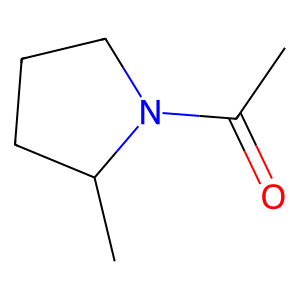

In [59]:
# draw a structure
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
s = "CC(=O)N1CCCC1C"
Draw.MolToImage(Chem.MolFromSmiles(s), size=(300, 300))

Morgan FP similarity:  0.5509562492370605
Help me modify the following SMILES:  CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
We need to remove the following fragments from the smiles: 
CC(C)N
CC(N)=O

CCCCC
CCC
CCCC
CCC
CCC
CCCCC
CCC


And we need to add the following fragments to the smiles: 
CC(C)N

CC(C)O
CCC
CC(C)CC(C)N
CCN(C(C)=O)C(C)C
CCC
CCCCN
CC(N)=O
CCN
CC(=O)N1CCCC1C
CC(C)N
CCC(C)C
CC(C)N(C)C
CC1CCCN1C
CN(C)C
CCC
CCCN(C)C
CCCC(C)N


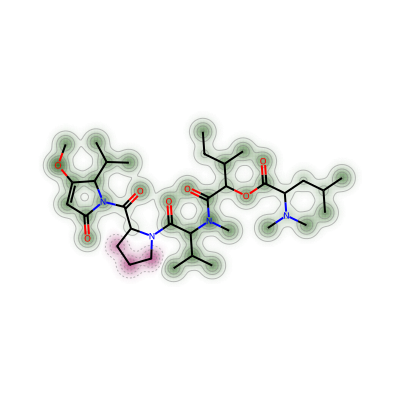

Morgan FP similarity:  0.5433564186096191
Help me modify the following SMILES:  CCC(C)C(OC(=O)C(CC(C)C)N(C)C(C)=O)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
We need to remove the following fragments from the smiles: 
CC(C)N
CN(C)C
CC(N)=O

CCCCC
CCC
CCCC
CCC
CCC
CCCCC
CCC


And we need to add the following fragments to the smiles: 
CC(C)N

CC(C)O
CCC
CC(C)CC(C)N
CC
CCN(C(C)=O)C(C)C
CCC
CCCCN
CC(N)=O
CC(N)=O
CCN
CC(=O)N1CCCC1C
CC(C)N
CCC(C)C
CC1CCCN1C
CN(C)C
CCC
CCCN(C)C
CCCC(C)N


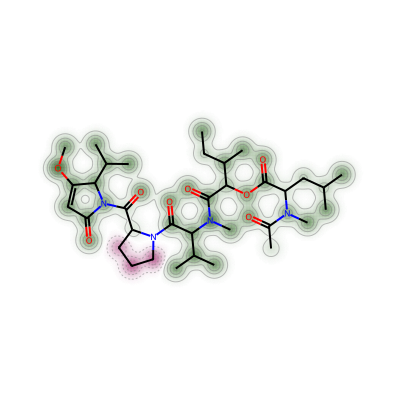

Morgan FP similarity:  0.5671642422676086
Help me modify the following SMILES:  COC1=CC(=O)N(C(=O)C2CCCN2C(=O)C(C(C)C)N(C)C(=O)C(OC(=O)C(CC(C)C)N(C)C)C(C)C)C1C(C)C
We need to remove the following fragments from the smiles: 
CCC(C)C
CC(C)N
CC(N)=O

CCCCC
CCC
CCCC
CCC
CC
CCC
CCCCC
CCC
CC(C)C


And we need to add the following fragments to the smiles: 
CC(C)N

CC(=O)N1CCCC1C
CC(C)O
CCN(C(C)=O)C(C)C
CN(C)C
CCCN(C)C
CC(C)N
CCC
CCC
CCCCN
CC(N)=O
CCC(C)C
CC(C)N(C)C
CC1CCCN1C
CCCC(C)N
CC(C)CC(C)N
CCN


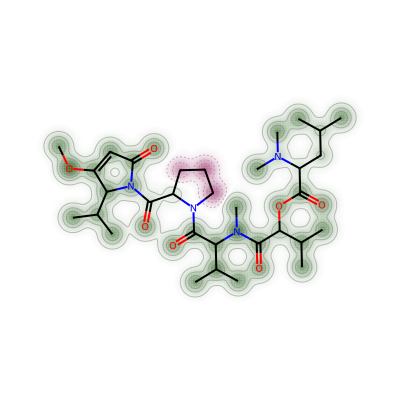

Morgan FP similarity:  0.5474767684936523
Help me modify the following SMILES:  CCC(C)C(O)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
We need to remove the following fragments from the smiles: 
CC(C)N
CN(C)C
CC(C)C
CC(N)=O

CCCCC
CCC
CCC
COC
CCCC
CCC
CCC
CCCCC
CCC
CC(=O)O


And we need to add the following fragments to the smiles: 

CO

CC(=O)N1CCCC1C
CCN(C(C)=O)C(C)C
CN(C)C
CCC
CC(C)N
CCCN(C)C
CCC
CCC
CCCCN
CC(N)=O
CC1CCCN1C
CCCC(C)N
CC(C)O
CCN


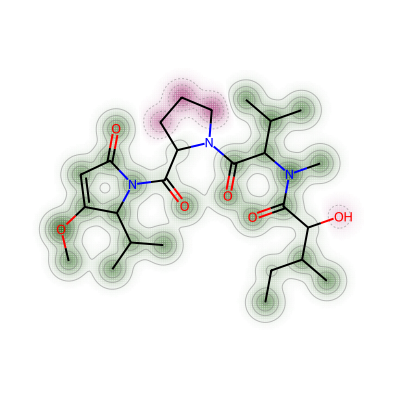

Morgan FP similarity:  0.5541085004806519
Help me modify the following SMILES:  CCC(C)C(C(=O)N1C(=O)C=C(OC)C1Cc1ccccc1)N(C)C(=O)C(C(C)C)N(C)C(=O)C(NC(=O)C(C(C)C)N(C)C)C(C)C
We need to remove the following fragments from the smiles: 
CC(C)C
CC(N)=O

CCCCC
CCC
CC(C)C
CCC
CC(C)N
COC
CCCC
CCC
CC(C)C(C)N
CCC
CCCCC
CCC
CC(=O)O


And we need to add the following fragments to the smiles: 
ccc
CC(=O)NC(C)C
cccc(c)C
ccc
ccccc

CC(C)C(C)N
cc(c)C
Cc1ccccc1
ccccc
c1ccccc1
ccc(cc)CC
CC(N)=O
CNC
cc(c)CC(C)N
CC(N)Cc1ccccc1
CC(C)N
CCC
CCc
CCc1ccccc1


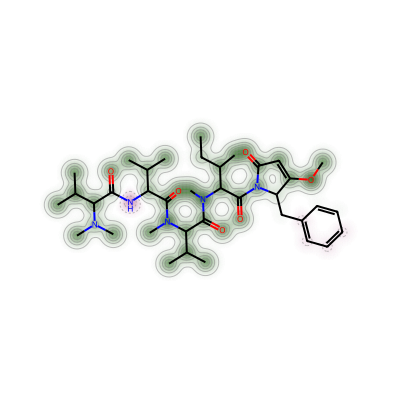

([], [])

In [ ]:

compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK_show_diff_frags(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, k=5 , ground_smiles=Kavaratamide_A_SMILES,)

_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7313103079795837



________retival #1, cosine similarity to prediction: 0.7528764605522156_________________
________retival's   cosine similarity to ground truth:  0.5669269561767578
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name 102151781


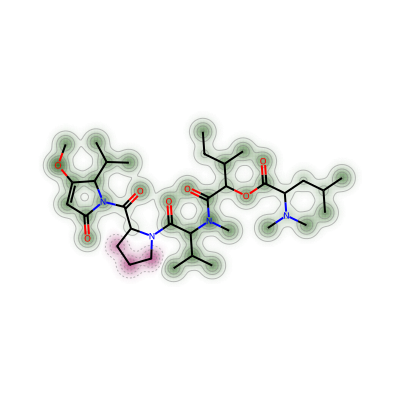

________retival #2, cosine similarity to prediction: 0.7422462701797485_________________
________retival's   cosine similarity to ground truth:  0.5669269561767578
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C(C)=O)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name 102469896


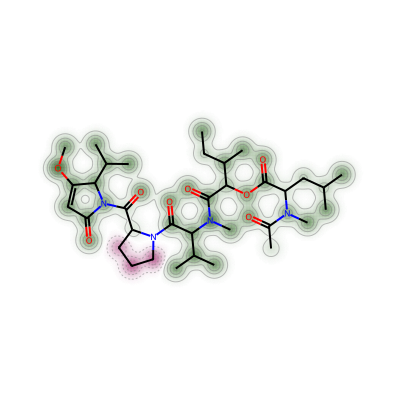

________retival #3, cosine similarity to prediction: 0.7260408401489258_________________
________retival's   cosine similarity to ground truth:  0.5688313245773315
SMILES: COC1=CC(=O)N(C(=O)C2CCCN2C(=O)C(C(C)C)N(C)C(=O)C(OC(=O)C(CC(C)C)N(C)C)C(C)C)C1C(C)C
Name 15168433


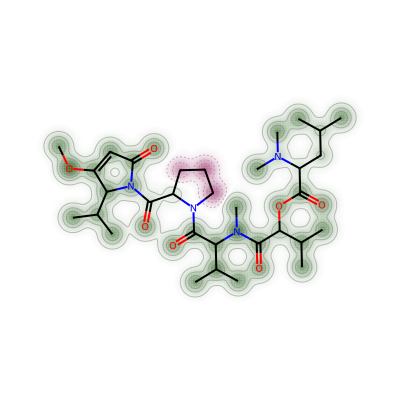

(['CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C',
  'CCC(C)C(OC(=O)C(CC(C)C)N(C)C(C)=O)C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C',
  'COC1=CC(=O)N(C(=O)C2CCCN2C(=O)C(C(C)C)N(C)C(=O)C(OC(=O)C(CC(C)C)N(C)C)C(C)C)C1C(C)C'],
 ['102151781', '102469896', '15168433'])

In [22]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   similarity_mapping_showing = "DB_Specific_Radius", filter_by_MW="from_input",
                #    weight_pred = torch.tensor(-fp_loader.total_entropy_of_all_bits).to("cuda").float()
                )
                   

In [21]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model_DB_specific_FP(model_type)
        max_radius = fp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [22]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

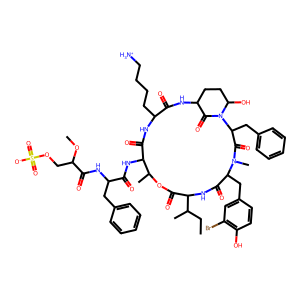

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [23]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

In [24]:
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

retival #1, cosine similarity between retrieval and ground truth: 0.8002593517303467_____________________________
retrived FP [0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086386844515800

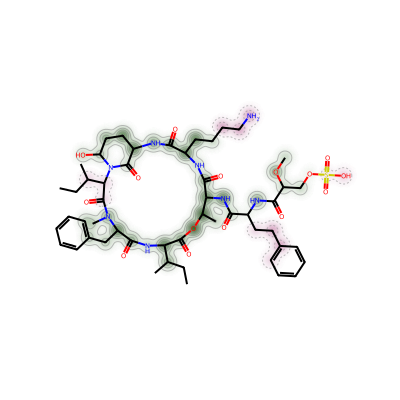

retival #2, cosine similarity between retrieval and ground truth: 0.7915244102478027_____________________________
retrived FP [0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

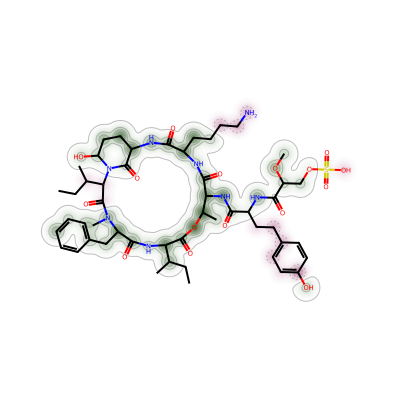

In [25]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.703415036201477



________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 49766272


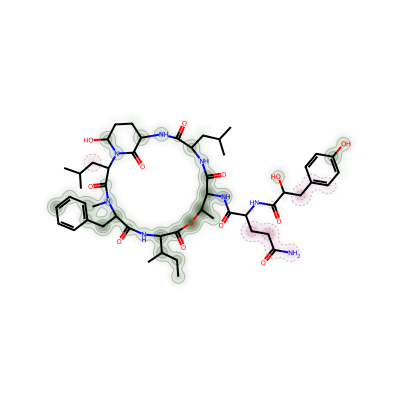

________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O
Name "[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"


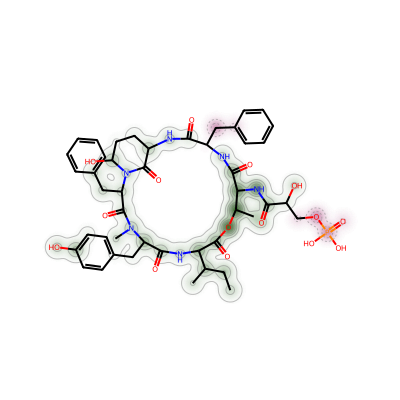

________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 102041486


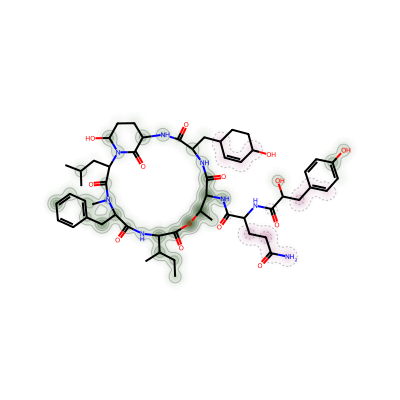

(['CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O'],
 ['49766272',
  '"[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"',
  '102041486'])

In [26]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [27]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




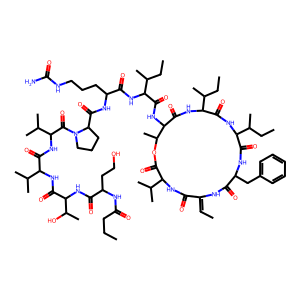

(['Oligopeptides'], False)

In [28]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

retival #1, cosine similarity between retrieval and ground truth: 0.9006819128990173_____________________________
retrived FP [0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356

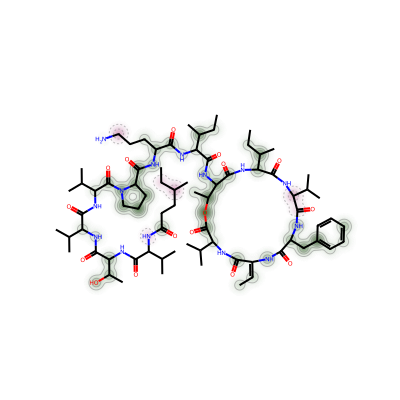

In [29]:
newCompoundB_FP = fp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7403514385223389



________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-

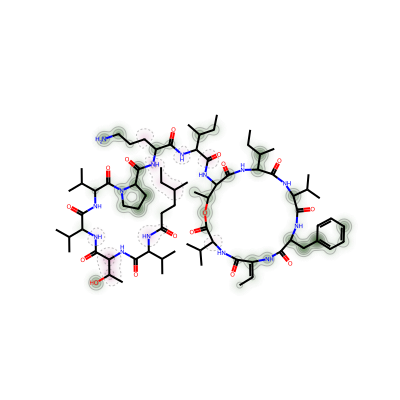

________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


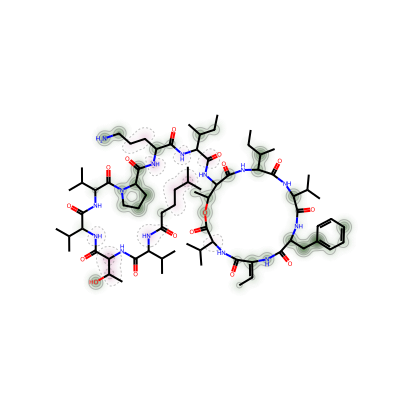

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"',
  '9898671'])

In [30]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.8439829349517822



________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


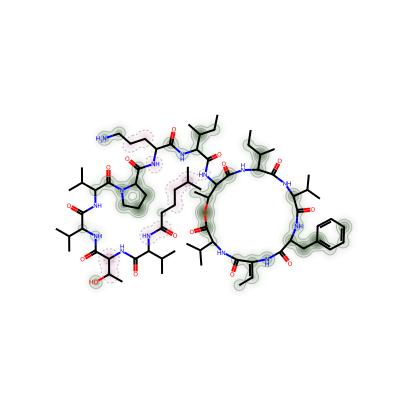

________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-but

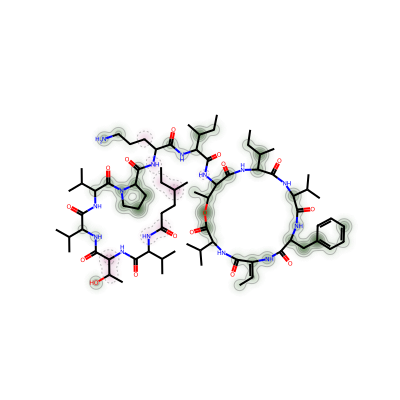

________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 5-OHKF


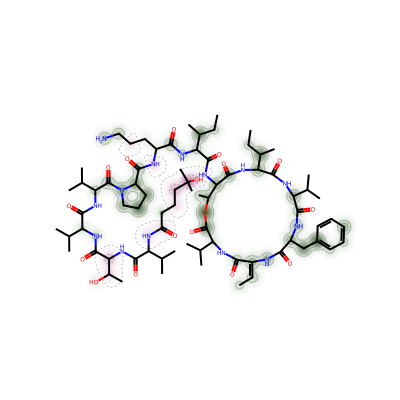

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['9898671',
  '"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methy

In [31]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [32]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [33]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)

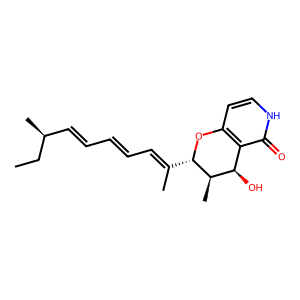




Aculeapyridone A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7674214243888855



________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
SMILES: CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C
Name YCM1008A


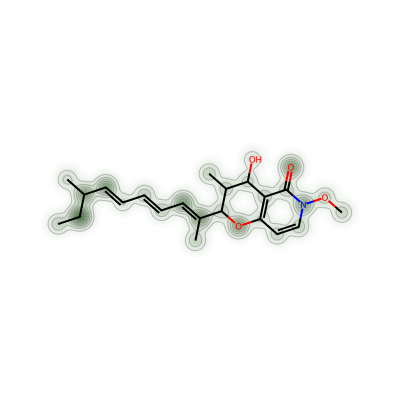

________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
SMILES: CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO
Name "4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"


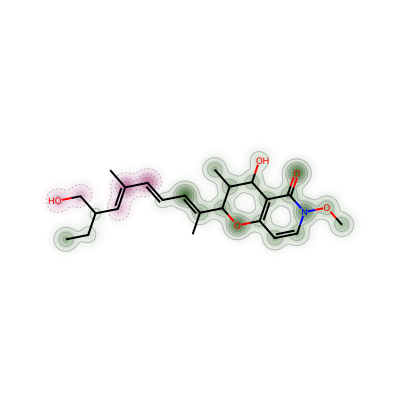

________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
SMILES: CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C
Name "(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"


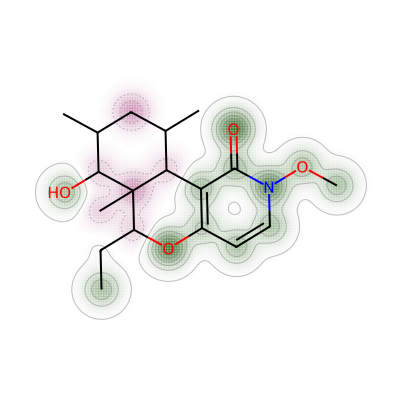

(['CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C',
  'CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO',
  'CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C'],
 ['YCM1008A',
  '"4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"',
  '"(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"'])

In [47]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Aculeapyridone A"

smiles, img = draw_mol_from_dir(compound_dir)

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles), filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")